In [90]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
%matplotlib inline
import sys
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multiprocessing import Pool
from functools import partial

from CrossValidation import *
from FeatureSimilarity import GetTopGenes, GetTopGenesMulti
from MatrixFactorization import CreateLatentVariables, FactorizeMatrix, GetRepresentationError

from utils import *

In [103]:
plt.rcParams['figure.figsize'] = [8, 6]
sns.set(font_scale=1.5)

In [4]:
totalDataDF = pd.read_csv('/projects/leelab3/psturm/concatData/totalDataDF.csv', header=0, index_col=0)
binaryPathwayDF = pd.read_csv('/projects/leelab3/psturm/concatData/pathways.tsv', sep='\t', header=0)
binaryPathwayDF.set_index('Genes', inplace=True)

In [86]:
totalDataDF.tail()

,488395315,496100277,496100278,496100279,496100281,496100283,496100284,496100285,496100287,496100288,...,1021204186,3451205016,4971205156,5371205166,1731204246,1321204196,4291205076,1081204186,651204176,2581204266
PCG,,,,,,,,,,,,,,,,,,,,,
BRAAK,0.500000,0.500000,1.000000,1.000000,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,...,0.333333,0.166667,0.833333,0.833333,0.833333,0.666667,0.500000,0.666667,0.500000,0.833333
CERAD,1.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.666667,...,0.666667,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.666667,0.000000,0.666667
PLAQUES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.193955,0.000000,0.424560,0.549603,0.569194,0.000000,0.207878,0.306999,0.000000,0.192465
ABETA_IHC,0.466675,0.038185,0.004278,0.010662,0.033745,0.040946,0.010449,0.355101,0.132327,0.035876,...,0.200114,0.022805,0.244584,0.479285,0.022235,0.000000,0.214177,0.502471,0.000000,0.309768
TAU_IHC,0.096909,0.002176,0.000532,0.000806,0.510205,0.001087,0.001712,0.001887,0.012920,0.120113,...,0.000000,0.000000,0.047492,0.029338,0.038281,0.000000,0.001878,0.000102,0.000162,0.000638


In [87]:
numReps = 100
braakIndex = 16864
phenotypeIndices  = np.arange(braakIndex, totalDataDF.shape[0])
braakCeradIndices = phenotypeIndices[0:2]
bioPhenoIndices   = phenotypeIndices[2:]
geneIndices = np.arange(braakIndex)

In [5]:
dropNanDF = totalDataDF.dropna(axis=0, how='all')
dropNanDF = dropNanDF.loc[:, ~pd.isnull(dropNanDF.loc[['BRAAK']]).values[0]]
dropNanDF = dropNanDF.T.fillna(dropNanDF.mean(axis=1)).T

In [6]:
X = dropNanDF.values.T
n, g = X.shape
half_n = int(n / 2)
X_phen = dropNanDF.index.get_loc('BRAAK')
X_gene = np.arange(X_phen)

In [73]:
def ApplyIntersection(trainList, valdList, numMax=2000):
    intersection_list = np.zeros((numMax, ))
    intersection_list[0] = int(trainList[0] == valdList[0])
    for i in range(1, numMax):
        intersection_list[i] = intersection_list[i - 1] + int(np.isin(trainList[i], valdList[:min(i + 1, len(valdList))]))
        if i < len(valdList):
            intersection_list[i] += int(np.isin(valdList[i], trainList[:i]))
    return intersection_list
    
def GetIntersections(rep):
    print(rep, end=',')
    numMax = 2000
    intersection_mat = np.zeros((8, 2000))
    
    V_train = np.load('/projects/leelab3/psturm/realModels/overlapModels/V_train{}.npy'.format(rep))
    V_vald = np.load('/projects/leelab3/psturm/realModels/overlapModels/V_vald{}.npy'.format(rep))
    
    intersection_mat[0, :] = ApplyIntersection(GetTopGenes(V_train, braakIndex, geneIndices, rankType='dot'),  GetTopGenes(V_vald, braakIndex, geneIndices, rankType='dot'))
    intersection_mat[1, :] = ApplyIntersection(GetTopGenes(V_train, braakIndex, geneIndices, rankType='corr'), GetTopGenes(V_vald, braakIndex, geneIndices, rankType='corr'))
    intersection_mat[2, :] = ApplyIntersection(GetTopGenes(V_train, braakIndex, geneIndices, rankType='dist'),  GetTopGenes(V_vald, braakIndex, geneIndices, rankType='dist'))
    intersection_mat[3, :] = ApplyIntersection(GetTopGenes(V_train, braakIndex, geneIndices, rankType='dist', sortFunc=None), GetTopGenes(V_vald, braakIndex, geneIndices, rankType='dist', sortFunc=None))
    
    randomIndices = np.loadtxt('/projects/leelab3/psturm/realData/randomIndices/perm{}.csv'.format(rep), dtype=int)
    randomIndices = randomIndices[randomIndices < n]
    trainIndices  = randomIndices[:half_n]
    valdIndices   = randomIndices[half_n:]
    trainX = X[trainIndices, :]
    valdX  = X[valdIndices, :]
    
    intersection_mat[4, :] = ApplyIntersection(GetTopGenes(trainX.T, X_phen, X_gene, rankType='dot'),  GetTopGenes(valdX.T, X_phen, X_gene, rankType='dot'))
    intersection_mat[5, :] = ApplyIntersection(GetTopGenes(trainX.T, X_phen, X_gene, rankType='corr'), GetTopGenes(valdX.T, X_phen, X_gene, rankType='corr'))
    intersection_mat[6, :] = ApplyIntersection(GetTopGenes(trainX.T, X_phen, X_gene, rankType='cos'),  GetTopGenes(valdX.T, X_phen, X_gene, rankType='cos'))
    intersection_mat[7, :] = ApplyIntersection(GetTopGenes(trainX.T, X_phen, X_gene, rankType='dist', sortFunc=None), GetTopGenes(valdX.T, X_phen, X_gene, rankType='dist', sortFunc=None))
    
    return intersection_mat

In [98]:
def GetNewIntersections(rep):
    print(rep, end=',')
    numMax = 2000
    intersection_mat = np.zeros((9, 2000))
    
    V_train = np.load('/projects/leelab3/psturm/realModels/overlapModels/V_train{}.npy'.format(rep))
    V_vald = np.load('/projects/leelab3/psturm/realModels/overlapModels/V_vald{}.npy'.format(rep))
    
    intersection_mat[0, :] = ApplyIntersection(GetTopGenesMulti(V_train, phenotypeIndices, geneIndices, aggFunc=np.mean),  
                                               GetTopGenesMulti(V_vald,  phenotypeIndices, geneIndices, aggFunc=np.mean), numMax)
    intersection_mat[1, :] = ApplyIntersection(GetTopGenesMulti(V_train, braakCeradIndices, geneIndices, aggFunc=np.mean),  
                                               GetTopGenesMulti(V_vald,  braakCeradIndices, geneIndices, aggFunc=np.mean), numMax)
    intersection_mat[2, :] = ApplyIntersection(GetTopGenesMulti(V_train, bioPhenoIndices, geneIndices, aggFunc=np.mean),  
                                               GetTopGenesMulti(V_vald,  bioPhenoIndices, geneIndices, aggFunc=np.mean), numMax)
    
    intersection_mat[3, :] = ApplyIntersection(GetTopGenesMulti(V_train, phenotypeIndices, geneIndices, aggFunc=np.min),  
                                               GetTopGenesMulti(V_vald,  phenotypeIndices, geneIndices, aggFunc=np.min), numMax)
    intersection_mat[4, :] = ApplyIntersection(GetTopGenesMulti(V_train, braakCeradIndices, geneIndices, aggFunc=np.min),  
                                               GetTopGenesMulti(V_vald,  braakCeradIndices, geneIndices, aggFunc=np.min), numMax)
    intersection_mat[5, :] = ApplyIntersection(GetTopGenesMulti(V_train, bioPhenoIndices, geneIndices, aggFunc=np.min),  
                                               GetTopGenesMulti(V_vald,  bioPhenoIndices, geneIndices, aggFunc=np.min), numMax)
    
    intersection_mat[6, :] = ApplyIntersection(GetTopGenesMulti(V_train, phenotypeIndices, geneIndices, aggFunc=np.max),  
                                               GetTopGenesMulti(V_vald,  phenotypeIndices, geneIndices, aggFunc=np.max), numMax)
    intersection_mat[7, :] = ApplyIntersection(GetTopGenesMulti(V_train, braakCeradIndices, geneIndices, aggFunc=np.max),  
                                               GetTopGenesMulti(V_vald,  braakCeradIndices, geneIndices, aggFunc=np.max), numMax)
    intersection_mat[8, :] = ApplyIntersection(GetTopGenesMulti(V_train, bioPhenoIndices, geneIndices, aggFunc=np.max),  
                                               GetTopGenesMulti(V_vald,  bioPhenoIndices, geneIndices, aggFunc=np.max), numMax)
    
    return intersection_mat

In [94]:
# numProcesses = 50
# p = Pool(numProcesses)
# tg_zipped = p.map(GetIntersections, range(numReps))
# p.close()
# p.join()

In [75]:
# tg_stacked = np.stack(tg_zipped, axis=0) #of shape numReps, 4, numPlotPoints

In [99]:
numProcesses = 50
p = Pool(numProcesses)
multi_zipped = p.map(GetNewIntersections, range(numReps))
p.close()
p.join()
multi_stacked = np.stack(multi_zipped, axis=0)

31,72,45,68,25,69,34,53,19,84,10,56,47,50,1,63,38,71,33,85,13,99,22,70,43,93,16,79,41,52,5,80,9,90,24,54,37,58,20,59,8,89,17,78,7,65,39,66,36,67,44,61,48,62,23,83,15,95,46,73,12,96,4,64,6,94,21,81,14,92,0,97,49,55,11,87,29,60,42,57,40,86,18,75,26,51,3,88,27,82,28,98,35,76,30,91,2,77,32,74,

In [110]:
def plotIndices(tg_df, names, indices, x_values, x_name, y_name, ci=None, ax=None, palette=sns.color_palette('tab10')):
    dfs = []
    for i in range(len(indices)):
        dfs.append(MatToMeltDF(tg_df[:, indices[i], :], group_name = names[i], x_values=x_values, x_name=x_name, y_name=y_name))
    if ax is not None:
        sns.lineplot(x=x_name, y=y_name, hue='group', data=pd.concat(dfs), ci=ci, ax=ax, palette=palette)
    else:
        sns.lineplot(x=x_name, y=y_name, hue='group', data=pd.concat(dfs), ci=ci, palette=palette)

In [116]:
sns.color_palette("tab10")[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

index 0, name mean_all
index 1, name mean_bc
index 2, name mean_bio
index 3, name min_all
index 4, name min_bc
index 5, name min_bio
index 6, name max_all
index 7, name max_bc
index 8, name max_bio


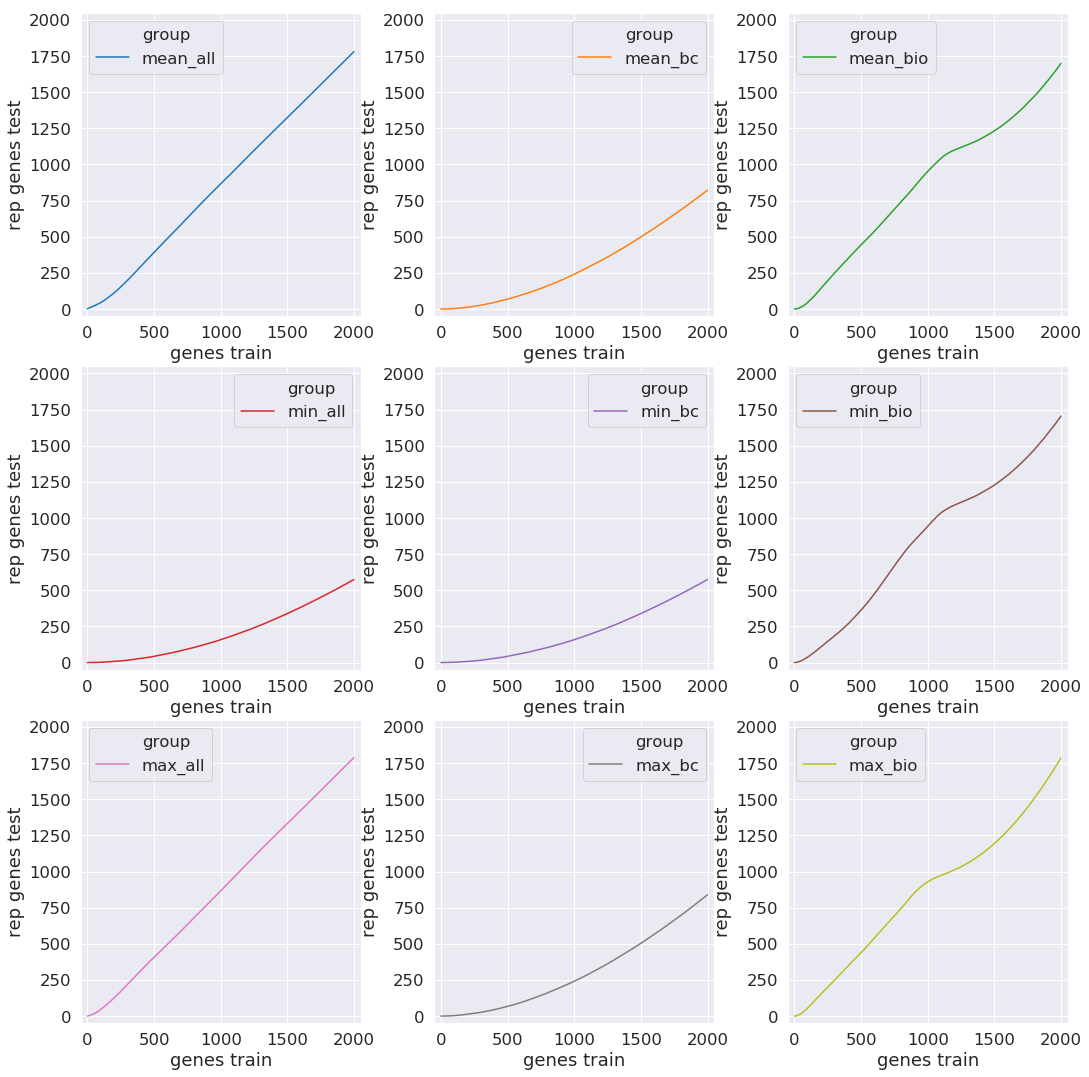

In [124]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.tight_layout()

aggFunc = ['mean', 'min', 'max']
phenName = ['all', 'bc', 'bio']
for i in range(3):
    for j in range(3):
        palette = [sns.color_palette("tab10")[i * 3 + j]]
        print('index {}, name {}'.format(i * 3 + j, '{}_{}'.format(aggFunc[i], phenName[j])))
        plotIndices(multi_stacked, names=['{}_{}'.format(aggFunc[i], phenName[j])], indices=[i * 3 + j], x_values=np.arange(2000), 
                    x_name='genes train', y_name='rep genes test', ci=None, ax=axs[i, j], palette=palette)
#         axs[i,j].set_title('{}_{}'.format(aggFunc[i], phenName[i]))
        axs[i, j].set_xlim(-50, 2050)
        axs[i, j].set_ylim(-50, 2050)
        
# plotIndices(multi_stacked, names=['mean_all', 'mean_bc', 'mean_bio', 'min_all', 'min_bc', 'min_bio', 'max_all', 'max_bc', 'max_bio'],
#            indices=range(9), x_values=np.arange(2000), x_name=x_name, y_name=y_name, ci=None)

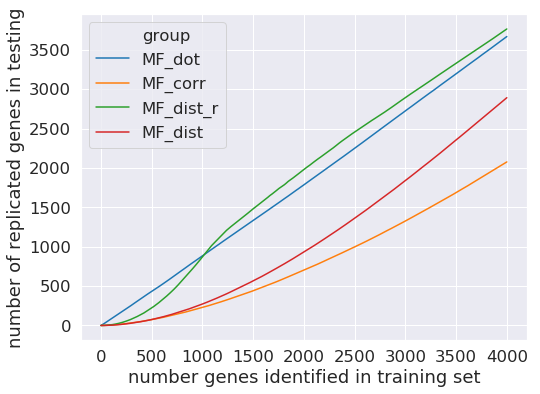

In [76]:
x_name = 'number genes identified in training set'
y_name = 'number of replicated genes in testing'
plotIndices(tg_stacked, names=['MF_dot', 'MF_corr', 'MF_dist_r', 'MF_dist'], indices=range(4), x_values=np.arange(4000), x_name=x_name, y_name=y_name, ci=None)

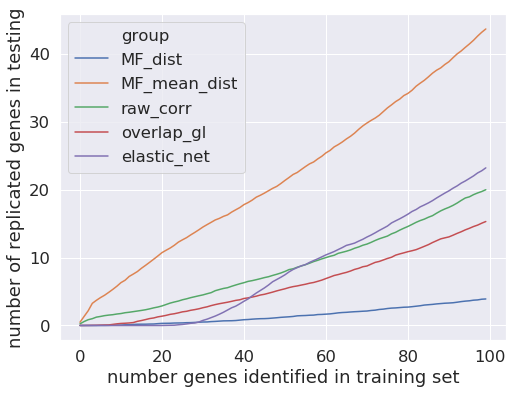

In [126]:
x_values = np.arange(100)
baseSaveDir = 'DataFrames/RealData/{}'
elastic_net_mat = pd.read_csv(baseSaveDir.format('elastic_net.csv')).values.T
elastic_net_df  = MatToMeltDF(elastic_net_mat, group_name='elastic_net', x_values=x_values, x_name=x_name, y_name=y_name)

overlap_gl_mat  = pd.read_csv(baseSaveDir.format('overlap_gl.csv')).values.T
overlap_gl_df = MatToMeltDF(overlap_gl_mat, group_name='overlap_gl', x_values=x_values, x_name=x_name, y_name=y_name)

MF_dot = MatToMeltDF(tg_stacked[:, 0, :], group_name='MF_dot', x_values=x_values, x_name=x_name, y_name=y_name)
MF_mean_df = MatToMeltDF(multi_stacked[:, 0, :], group_name='MF_mean_dist', x_values=x_values, x_name=x_name, y_name=y_name)
MF_df = MatToMeltDF(tg_stacked[:, 3, :], group_name='MF_dist', x_values=x_values, x_name=x_name, y_name=y_name)
corr_df = MatToMeltDF(tg_stacked[:, 5, :], group_name='raw_corr', x_values=x_values, x_name=x_name, y_name=y_name)

colors = sns.color_palette('tab10')
sns.lineplot(x=x_name, y=y_name, hue='group', 
             data=pd.concat([MF_df, MF_mean_df, corr_df, overlap_gl_df, elastic_net_df]), ci=None)#, palette=(colors[:1] + colors[2:5]))

In [ ]:
x_values = np.arange(1000)
baseSaveDir = 'DataFrames/RealData/{}'
elastic_net_mat = pd.read_csv(baseSaveDir.format('elastic_net.csv')).values.T
elastic_net_df  = MatToMeltDF(elastic_net_mat, group_name='elastic_net', x_values=x_values, x_name=x_name, y_name=y_name)

overlap_gl_mat  = pd.read_csv(baseSaveDir.format('overlap_gl.csv')).values.T
overlap_gl_df = MatToMeltDF(overlap_gl_mat, group_name='overlap_gl', x_values=x_values, x_name=x_name, y_name=y_name)

MF_df_r = MatToMeltDF(tg_stacked[:, 2, :], group_name='MF_dist_r', x_values=x_values, x_name=x_name, y_name=y_name)
MF_df = MatToMeltDF(tg_stacked[:, 3, :], group_name='MF_dist', x_values=x_values, x_name=x_name, y_name=y_name)
MF_df_avg = MatToMeltDF((tg_stacked[:, 3, :] + tg_stacked[:, 2, :])/2, group_name='MF_dist_avg', x_values=x_values, x_name=x_name, y_name=y_name)
corr_df = MatToMeltDF(tg_stacked[:, 5, :], group_name='raw_corr', x_values=x_values, x_name=x_name, y_name=y_name)

colors = sns.color_palette('tab10')
sns.lineplot(x=x_name, y=y_name, hue='group', 
             data=pd.concat([MF_df, MF_df_r, corr_df, overlap_gl_df, elastic_net_df]), ci=None)